In [ ]:
# Importing necessary libraries for deep learning, including TensorFlow, Keras (for model building),
#pre-trained architectures (MobileNetV2, ResNet50), optimization (Adam), image preprocessing (ImageDataGenerator),
#and callbacks (EarlyStopping), along with visualization (matplotlib) and TensorFlow Datasets (tfds) for loading datasets.

from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

import matplotlib.pyplot as plt


This section of the code loads the Imagenette dataset, a subset of ImageNet designed for quick experimentation, using TensorFlow Datasets (tfds). It specifies the image size (IMG_SIZE = 32) and batch size (BATCH_SIZE = 32). The dataset is split into training and validation sets, and the as_supervised=True option ensures that the data is returned as (image, label) pairs for supervised learning tasks.








In [ ]:
# Load the Imagenette dataset
IMG_SIZE = 32
BATCH_SIZE = 32

train_data, val_data = tfds.load(
    "imagenette/full-size-v2",
    split=["train", "validation"],
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

This section of the code loads the CIFAR-10 dataset, a collection of 60,000 32x32 color images across 10 classes, using Keras's built-in dataset loader. The training and testing images are normalized by dividing pixel values by 255.0 to scale them to a range of [0, 1] for easier training. Images are resized to 32x32 pixels using TensorFlow's resize method to ensure consistency. Labels for both training and testing sets are converted into one-hot encoded vectors using Keras's to_categorical function to prepare them for multi-class classification.




In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train_resized = np.array([tf.image.resize(img, [32, 32]).numpy() for img in x_train])
x_test_resized = np.array([tf.image.resize(img, [32, 32]).numpy() for img in x_test])

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

This section defines data augmentation strategies for training and testing datasets using Keras's ImageDataGenerator.

train_datagen: Applies augmentation techniques such as random rotations (up to 20 degrees), horizontal shifts (width_shift_range=0.2), vertical shifts (height_shift_range=0.2), and horizontal flipping to artificially increase the diversity of the training dataset and reduce overfitting.

test_datagen: Provides a simple generator for the test dataset without augmentation, ensuring that test images remain unchanged for accurate evaluation.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

This section creates data generators for the training and testing datasets using the ImageDataGenerator objects defined earlier:

train_generator: Generates batches of augmented training data (x_train_resized and y_train) with a batch size of 32. The augmentation is applied on the fly to enhance the diversity of the training data.

test_generator: Generates batches of test data (x_test_resized and y_test) with a batch size of 32. No augmentation is applied to the test data, ensuring that the evaluation is performed on unaltered samples.

In [ ]:
train_generator = train_datagen.flow(x_train_resized, y_train, batch_size=32)
test_generator = test_datagen.flow(x_test_resized, y_test, batch_size=32)

This section initializes a MobileNetV2 model pre-trained on the ImageNet dataset as the base model for transfer learning:

MobileNetV2(weights="imagenet", include_top=False, input_shape=(32, 32, 3)): Loads MobileNetV2 without its top classification layers (include_top=False) and specifies the input shape as (32, 32, 3) for the CIFAR-10 dataset's image size and RGB channels.

base_model.trainable = True: Makes the base model trainable, allowing fine-tuning of its weights.

for layer in base_model.layers[:-20]: layer.trainable = False: Freezes all layers except the last 20, which are left trainable. This strategy helps retain the pre-trained features in earlier layers while enabling fine-tuning of deeper layers to adapt to the new dataset.

In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

This section defines a sequential model for image classification using the pre-trained MobileNetV2 as the backbone, with additional custom layers for fine-tuning and classification:

base_model: The pre-trained MobileNetV2 model serves as the feature extractor, providing powerful pre-trained representations for images.

GlobalAveragePooling2D(): Reduces the spatial dimensions of the feature maps from the base model by computing the average of each feature map, effectively summarizing the learned features.

Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)): Adds a fully connected layer with 128 neurons, ReLU activation, and L2 regularization to reduce overfitting.

BatchNormalization(): Normalizes the layer's activations, stabilizing and accelerating training.

Dropout(0.5): Randomly drops 50% of neurons during training to reduce overfitting and improve generalization.

Dense(10, activation="softmax"): The final output layer with 10 neurons (one for each class in CIFAR-10) and a softmax activation function for multi-class probability predictions.

In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

This section compiles and trains the model with specified parameters and includes an early stopping mechanism to optimize training:

model.compile(): Configures the model for training.

optimizer=Adam(learning_rate=1e-5): Uses the Adam optimizer with a small learning rate (1e-5) for fine-tuning.
loss="categorical_crossentropy": Specifies the loss function for multi-class classification.
metrics=["accuracy"]: Tracks accuracy as the evaluation metric during training.
early_stopping: Implements early stopping to prevent overfitting and reduce unnecessary computation.

monitor="val_loss": Monitors the validation loss to decide when to stop training.
patience=5: Stops training if the validation loss doesn't improve for 5 consecutive epochs.
restore_best_weights=True: Restores the model weights to the best state observed during training.
model.fit(): Trains the model using the data generators.

train_generator: Supplies augmented training data.
validation_data=test_generator: Supplies testing data for validation during training.
epochs=50: Specifies a maximum of 50 training epochs.
callbacks=[early_stopping]: Includes the early stopping mechanism to terminate training early if needed.
The model will train on the data while monitoring validation loss, and training will stop automatically if no improvement is observed, ensuring efficient use of resources.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=[early_stopping]
)



This code plots the training and validation accuracy over epochs to visualize the model's performance. It helps identify trends such as improvements in accuracy, convergence, or potential overfitting, where the validation accuracy plateaus or diverges from training accuracy. The graph provides a clear comparison of how the model performs on both the training and validation datasets across the training process.

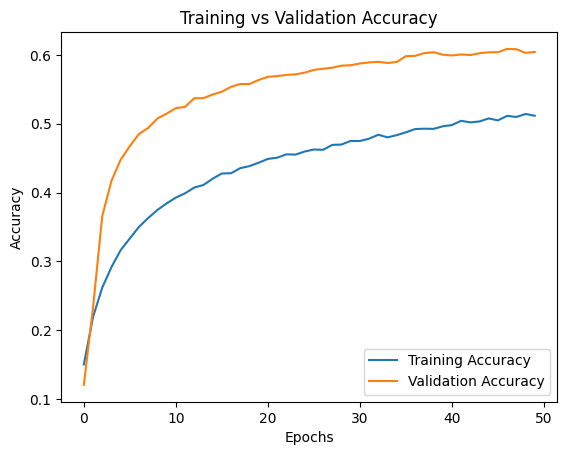

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


This section evaluates the trained model's performance on the test dataset:

model.evaluate(test_generator, verbose=2):

Evaluates the model using the test data provided by test_generator.
Computes both the test loss (test_loss) and the test accuracy (test_acc).
The verbose=2 parameter displays progress messages, summarizing the evaluation results.
print(f"Test Accuracy: {test_acc:.2f}"):

Prints the test accuracy as a percentage formatted to two decimal places.

The model processed 313 batches in 2 seconds, taking 5 milliseconds per step.
Achieved a test accuracy of 60.44% and a test loss of 1.4358.

The printed accuracy rounds the value to two decimal places (60%).

This indicates the model has moderate performance on the test dataset, with room for improvement in accuracy and loss reduction.








In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")

313/313 - 2s - 5ms/step - accuracy: 0.6044 - loss: 1.4358
Test Accuracy: 0.60
